In this example, we show how to use our RTify framework to get reaction times(RTs). In this example, we only use synthetic human data and transformer.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from utils import set_seeds
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import math

%matplotlib inline
set_seeds()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# for illustative purposes, here we use FashionMNIST train set as a toy dataset
data_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
# As an example, we will use the mean of the image as a proxy for the RTs
data_train = [(x, y, x.mean()) for x, y in data_train]
rt_array = np.array([x[2] for x in data_train])
# for our fake RT, we normalize the RTs to be between 0 and 1
rt_array = (rt_array - rt_array.min()) / (rt_array.max() - rt_array.min())
# assign the normalized RTs back to the dataset
data_train = [(item[0], item[1], torch.tensor(rt)) for item, rt in zip(data_train, rt_array)]
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True, drop_last=True)

In [4]:
from torch.autograd import Function

class DiffDecision(Function):
    @staticmethod
    def forward(ctx, trajectory, dsdt_trajectory):

        mask = trajectory > 0
        decision_time = mask.float().argmax(dim=1).float()
        decision_time[mask.sum(dim=1) == 0] = torch.tensor(trajectory.shape[1] - 1, dtype=torch.float32)
        ctx.save_for_backward(dsdt_trajectory, decision_time, trajectory)

        return decision_time

    @staticmethod
    def backward(ctx, grad_output):
        dsdt_trajectory, decision_times, trajectory = ctx.saved_tensors
        mask = trajectory > 0
        idx1 = (mask.sum(dim=1) == 0).long()
        idx2 = dsdt_trajectory[torch.arange(dsdt_trajectory.size(0)), decision_times.long()] < 0
        idx = torch.logical_and(idx1.bool(), idx2.bool())
        grads = torch.zeros_like(dsdt_trajectory)
        batch_indices = torch.arange(decision_times.size(0)).to(decision_times.device)

        grads[batch_indices, decision_times.long()] = -1.0 / (dsdt_trajectory[
            batch_indices, decision_times.long()] + 1e-6)
        grads[batch_indices[idx], decision_times[idx].long()] = 1e-6 / (
            trajectory[batch_indices[idx], decision_times[idx].long()] + 1e-6
        )
        grads = grads * grad_output.unsqueeze(1).expand_as(grads)
        return grads, None

In [5]:
# Positional Encoding for transformer tokens
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, T, D)
        x = x + self.pe[:, :x.size(1), :]
        return x

# Tiny Transformer RTify model
class RTify_Transformer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        num_heads: int,
        ff_dim: int,
        output_size: int,
        time_steps: int = 20,
        sigma: float = 2.0
    ):
        super().__init__()
        self.time_steps = time_steps
        self.embed = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=time_steps)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc_out = nn.Linear(embed_dim, output_size)

        # RTify components
        self.evidence = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1),
            nn.Tanh()
        )
        self.threshold = nn.Parameter(torch.tensor(6.0))
        self.sigma = sigma

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        device = x.device

        # Flatten image as token input: (B, input_dim)
        flat = x.view(B, -1)  # input_dim = C*H*W
        # Repeat token for time steps
        tokens = flat.unsqueeze(1).repeat(1, self.time_steps, 1)  # (B, T, input_dim)
        # Embed
        embedded = self.embed(tokens)  # (B, T, embed_dim)
        # Positional encoding
        embedded = self.pos_encoder(embedded)  # (B, T, embed_dim)
        # Transformer expects shape (T, B, D)
        trans_in = embedded.permute(1, 0, 2)  # (T, B, embed_dim)
        # Causal mask to prevent attending to future tokens
        mask = torch.triu(torch.ones(self.time_steps, self.time_steps, device=device) * float('-inf'), diagonal=1)
        hidden_states = self.transformer_encoder(trans_in, mask=mask)  # (T, B, embed_dim)
        # Permute back to (B, T, embed_dim)
        hidden_states = hidden_states.permute(1, 0, 2)

        # Classification logits: take weighted sum over time via soft attention (same as RTify logic)
        # First compute evidence trajectory for accumulation
        s_traj = self.evidence(hidden_states).squeeze(-1)  # (B, T)
        s_accumulated = torch.cumsum(s_traj, dim=1)  # (B, T)
        dsdt_trajectory = torch.diff(s_accumulated, dim=1)
        dsdt_trajectory = torch.cat((dsdt_trajectory[:, 0].unsqueeze(1), dsdt_trajectory), dim=1)  # (B, T)
        decision_time = DiffDecision.apply(s_accumulated - self.threshold, dsdt_trajectory)  # (B,)

        # Soft index over time
        time_range = torch.arange(self.time_steps, device=device).unsqueeze(0)  # (1, T)
        soft_index = torch.exp(-0.5 * (decision_time.unsqueeze(1) - time_range) ** 2 / self.sigma ** 2)
        soft_index = soft_index / soft_index.sum(dim=-1, keepdim=True)  # (B, T)

        # Logits per time step: project hidden to class logits
        logits_per_t = self.fc_out(hidden_states)  # (B, T, output_size)
        # Weighted sum
        soft_index = soft_index.unsqueeze(-1)  # (B, T, 1)
        decision_logits = (logits_per_t * soft_index).sum(dim=1)  # (B, output_size)

        # Return logits and normalized RT (decision_time+1 / T)
        rt_pred = (decision_time + 1) / self.time_steps
        return decision_logits, rt_pred

In [6]:
model = RTify_Transformer(input_dim=784, embed_dim=16, num_heads=2, ff_dim=32, output_size=10, time_steps=20).to(device)

# Loss functions and optimizer
epochs = 20
label_criterion = nn.CrossEntropyLoss()
rt_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Trackers
rt_loss_list, label_loss_list, acc_list, corr_list = [], [], [], []

for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    for x, y, rt in train_loader:
        x, y, rt = x.to(device), y.to(device), rt.to(device)
        optimizer.zero_grad()

        # Forward pass through Transformer RTify model
        logits, rt_pred = model(x)

        # Compute losses
        rt_loss_temp = rt_criterion(rt_pred, rt)
        label_loss_temp = label_criterion(logits, y)
        loss = rt_loss_temp + label_loss_temp

        # Logging
        rt_loss_list.append(rt_loss_temp.item())
        label_loss_list.append(label_loss_temp.item())
        acc = (logits.argmax(dim=-1) == y).float().mean().item()
        acc_list.append(acc)
        corr_val = torch.corrcoef(torch.stack([rt_pred.detach(), rt]))[0, 1].item() if rt_pred.numel() > 1 else 0.0
        corr_list.append(corr_val)

        # Backprop and update
        loss.backward()
        optimizer.step()

c:\Users\ycheng70\.conda\envs\llm-research\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

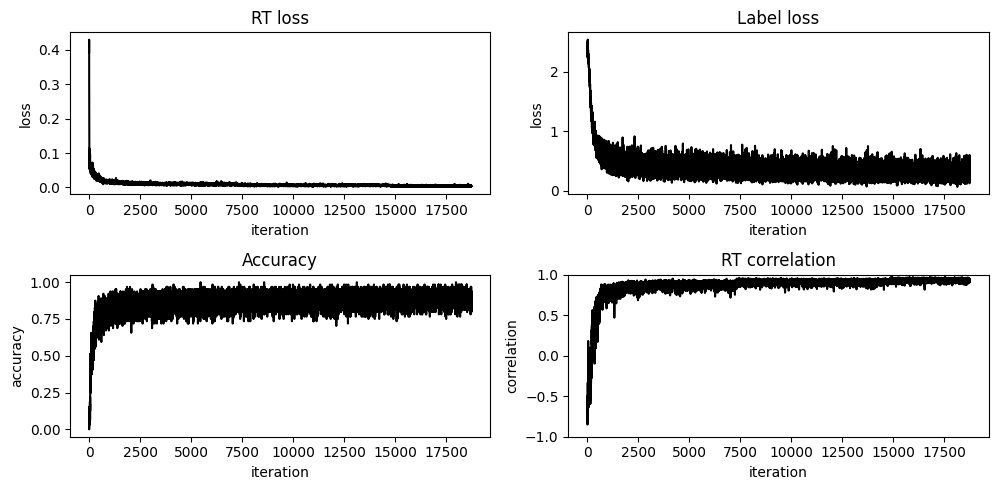

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()
ax[0].plot(np.array(rt_loss_list), '-k')
ax[0].set_title('RT loss')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')

ax[1].plot(np.array(label_loss_list), '-k')
ax[1].set_title('Label loss')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('loss')

ax[2].plot(np.array(acc_list), '-k')
ax[2].set_title('Accuracy')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('accuracy')

ax[3].plot(np.array(corr_list), '-k')
ax[3].set_ylim(-1, 1)
ax[3].set_title('RT correlation')
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('correlation')
plt.tight_layout()
plt.show()

In [8]:
model = RTify_Transformer(input_dim=784, embed_dim=64, num_heads=4, ff_dim=128, output_size=10, time_steps=20).to(device)

# Loss functions and optimizer
epochs = 20
label_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Trackers
rt_loss_list, label_loss_list, acc_list, avg_rt_list = [], [], [], []

for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    for x, y, rt in train_loader:
        x, y, rt = x.to(device), y.to(device), rt.to(device)
        optimizer.zero_grad()

        # Forward pass through Transformer RTify model
        logits, rt_pred = model(x)

        # Compute RT loss as mean RT
        rt_loss_temp = rt_pred.mean()
        # Compute classification loss
        label_loss_temp = label_criterion(logits, y)
        # Combined loss, weighting RT loss by factor 5.0
        loss = 5.0 * rt_loss_temp + label_loss_temp

        # Logging
        rt_loss_list.append(rt_loss_temp.item())
        label_loss_list.append(label_loss_temp.item())
        acc = (logits.argmax(dim=-1) == y).float().mean().item()
        acc_list.append(acc)
        avg_rt_list.append(rt_pred.mean().item())

        # Backprop and update
        loss.backward()
        optimizer.step()

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

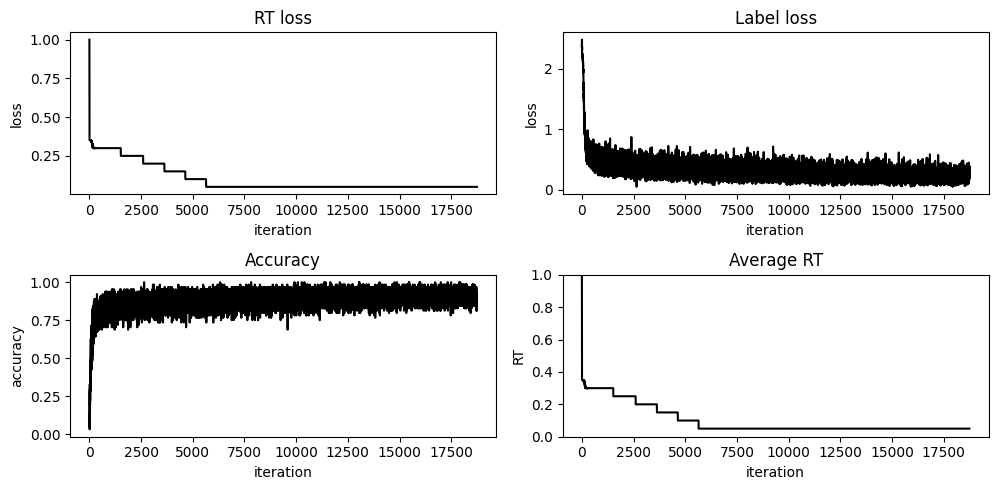

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()
ax[0].plot(rt_loss_list, '-k')
ax[0].set_title('RT loss')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')

ax[1].plot(label_loss_list, '-k')
ax[1].set_title('Label loss')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('loss')

ax[2].plot(acc_list, '-k')
ax[2].set_title('Accuracy')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('accuracy')

ax[3].plot(avg_rt_list, '-k')
ax[3].set_title('Average RT')
ax[3].set_ylim(0, 1)
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('RT')
plt.tight_layout()
plt.show()


In [14]:
model = RTify_Transformer(input_dim=784, embed_dim=64, num_heads=4, ff_dim=128, output_size=10, time_steps=20).to(device)

# Loss functions and optimizer
epochs = 20
label_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Trackers
rt_loss_list, label_loss_list, acc_list, avg_rt_list = [], [], [], []

for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    for x, y, rt in train_loader:
        x, y, rt = x.to(device), y.to(device), rt.to(device)
        optimizer.zero_grad()

        # Forward pass through Transformer RTify model
        logits, rt_pred = model(x)

        # Compute RT loss as mean RT
        rt_loss_temp = rt_pred.mean()
        # Compute classification loss
        label_loss_temp = label_criterion(logits, y)
        # Combined loss with reduced RT penalty
        loss = 0.02* rt_loss_temp + label_loss_temp

        # Logging
        rt_loss_list.append(rt_loss_temp.item())
        label_loss_list.append(label_loss_temp.item())
        acc = (logits.argmax(dim=-1) == y).float().mean().item()
        acc_list.append(acc)
        avg_rt_list.append(rt_pred.mean().item())

        # Backprop and update
        loss.backward()
        optimizer.step()

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

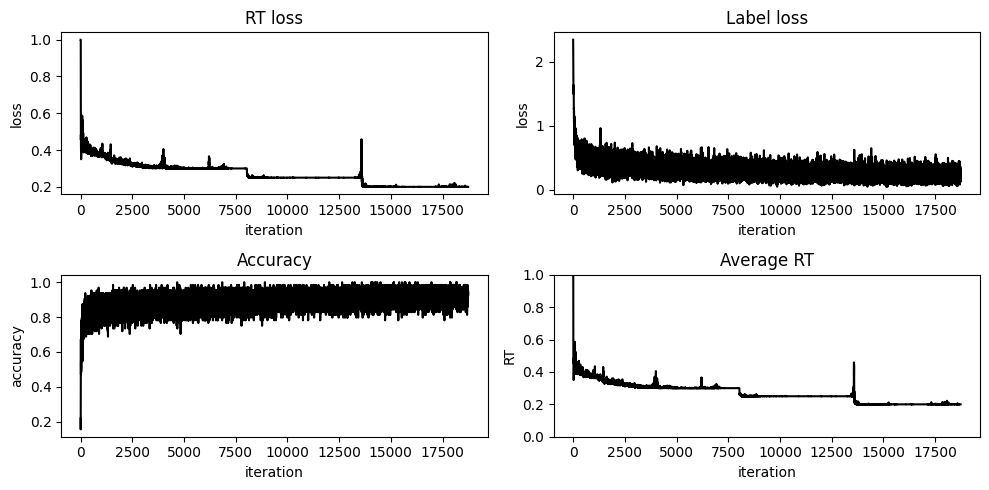

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.flatten()
ax[0].plot(rt_loss_list, '-k')
ax[0].set_title('RT loss')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')

ax[1].plot(label_loss_list, '-k')
ax[1].set_title('Label loss')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('loss')

ax[2].plot(acc_list, '-k')
ax[2].set_title('Accuracy')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('accuracy')

ax[3].plot(avg_rt_list, '-k')
ax[3].set_title('Average RT')
ax[3].set_ylim(0, 1)
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('RT')
plt.tight_layout()
plt.show()
